# Notebook for generating analysis and panels in Figure 2

In [1]:
%pylab
%matplotlib inline
%reload_ext autoreload
if sys.platform != 'darwin':
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-3.6.0" # change as needed
%load_ext rpy2.ipython

import pandas as pd
import sys
import seaborn as sns
sys.path.append('../../src')
import abrTools as at
import os
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
from collections import Counter
import pretty_confusion_matrix as pcm
from scipy.signal import savgol_filter


fs = 195000.0/2.0 # Acquisition sampling rate

from datetime import date
savefolder = os.path.join('../..','results',str(date.today()))


from matplotlib.pyplot import errorbar
rcParams["font.family"] = "Arial"
rcParams['axes.linewidth'] = 5
rcParams["xtick.major.size"] = 20
rcParams["xtick.major.width"] = 5
rcParams["xtick.major.pad"] = 10

rcParams["ytick.major.size"] = 20
rcParams["ytick.major.width"] = 5
rcParams["xtick.minor.size"] = 10
rcParams["xtick.minor.width"] = 5

rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
markersize=35
fontSize = 54*1.3
import matplotlib.gridspec as gridspec


Using matplotlib backend: <object object at 0x1057be440>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Load Dataset 

In [4]:
thresholds

,Click,3 kHz,6 kHz,12 kHz,18 kHz,24 kHz,30 kHz,36 kHz,42 kHz,MouseN - AGE
0,35,70,45,25,30,35,40,45,50,1_Repaired - 1month
1,35,80,45,25,25,30,50,55,55,2_Repaired - 1month
2,30,75,45,20,25,35,40,40,50,3_Repaired - 1month
3,35,80,40,15,20,30,40,40,40,4_Repaired - 1month
4,30,65,40,20,25,30,50,50,50,5_Repaired - 1month
...,...,...,...,...,...,...,...,...,...,...
393,70,80,55,80,100,100,100,100,100,48_6N - 12month
394,65,75,50,80,85,100,100,100,100,50_6N - 12month
395,40,75,40,35,80,100,100,100,100,49_6N - 12month
396,100,100,100,100,100,100,100,100,100,45_6N - 12month


In [6]:
frequencies = ['Click', '3 kHz', '6 kHz', '12 kHz', '18 kHz', '24 kHz',
       '30 kHz', '36 kHz', '42 kHz']

fs = 195000.0/2.0 # Acquisition sampling rate

data,thresholds,dataversion = at.loadFiles(datafolder='../../data')
thresholds['ID'] = thresholds['MouseN - AGE'].str.split(' - ',expand=True)[0].astype(str)
thresholds['Age (months)'] = thresholds['MouseN - AGE'].str.split(' - ',expand=True)[1].str.split('month',expand=True)[0].astype(int)
strain = []
for el in thresholds['ID']:
    strain.append(data.loc[data['ID']==el,'Strain'].values[0])
thresholds['Strain'] = strain

The dataset version is: None


# Audiogram panels

In [7]:
from scipy.stats import median_abs_deviation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def rand_jitter(arr):
    stdev = 4
    return arr + np.random.randn(len(arr)) * stdev

def makeAvgThreshFigure2(tr6N, trRepaired):
    """
    Generates a figure comparing the median and median absolute deviation (MAD) of two datasets.

    Parameters:
    tr6N (DataFrame): DataFrame containing the first dataset.
    trRepaired (DataFrame): DataFrame containing the second dataset.

    Returns:
    tuple: A tuple containing the two axes objects (ax, ax2) used in the figure.

    The function performs the following steps:
    1. Calculates the median and MAD for both datasets.
    2. Adjusts MAD values to ensure they do not exceed a threshold of 100.
    3. Sets up the x-axis values for the plot.
    4. Creates a figure and sets up a grid specification for subplots.
    5. Plots the individual data points and error bars for both datasets.
    6. Configures the appearance of the plots, including axis labels, limits, and scales.
    7. Adds a connection patch between the two subplots.
    8. Adds text annotations to the plot.
    9. Adjusts the layout of the figure.

    Note:
    - The function assumes that the global variables `markersize`, `fontSize`, and `age` are defined elsewhere in the code.
    - The function uses the `rand_jitter` function to add jitter to the scatter plot points.
    """
    med6N = tr6N.median()[:]
    mad6N = median_abs_deviation(tr6N)[:]
    mad6N[med6N + mad6N > 100] = 100 - med6N[med6N + mad6N > 100]

    medRep = trRepaired.median()[:]
    madRep = median_abs_deviation(trRepaired)[:]
    madRep[medRep + madRep > 100] = 100 - medRep[medRep + madRep > 100]

    x = np.arange(9)
    x[1:] = [3000, 6000, 12000, 18000, 24000, 30000, 36000, 42000]

    f = plt.figure(figsize=(3.7 * 2.5 * 1.6138, 3.7 * 2.5 * 1.2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5], hspace=0.002, figure=f)
    ax = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ax2.plot(x[1:], tr6N.values.T[1:, :], '#DC3220', alpha=0.25, linewidth=1)
    ax2.plot(x[1:], trRepaired.values.T[1:, :], '#005AB5', alpha=0.25, linewidth=1)

    ax.scatter(rand_jitter([x[0]] * tr6N.values.T.shape[1]), tr6N.values.T[0, :], edgecolor='#DC3220', color='none', alpha=0.35, s=markersize**2 / 3, marker='o', clip_on=False)
    ax.scatter(rand_jitter([x[0]] * trRepaired.values.T.shape[1]), trRepaired.values.T[0, :], edgecolor='#005AB5', color='none', alpha=0.35, s=markersize**2 / 3, marker='o', clip_on=False)

    ax2.errorbar(x[1:], med6N[1:], mad6N[1:], fmt='o', color='#DC3220', markersize=markersize, clip_on=False, capsize=10, linewidth=3, capthick=3, markeredgecolor='w', mew=2)
    ax2.plot(x[1:], med6N[1:], '-', color='#DC3220', linewidth=3)
    ax.errorbar(x[0], med6N[0], mad6N[0], fmt='o', color='#DC3220', markersize=markersize, clip_on=False, capsize=10, linewidth=3, capthick=3, markeredgecolor='w', mew=2)

    ax2.errorbar(x[1:], medRep[1:], madRep[1:], fmt='o', color='#005AB5', markersize=markersize, clip_on=False, capsize=10, linewidth=3, capthick=3, markeredgecolor='w', mew=2)
    ax2.plot(x[1:], medRep[1:], '-', color='#005AB5', linewidth=3)
    ax.errorbar(x[0], medRep[0], madRep[0], fmt='o', color='#005AB5', markersize=markersize, clip_on=False, capsize=10, linewidth=3, capthick=3, markeredgecolor='w', mew=2)

    ax2.set_ylim(0, 100)
    ax.set_ylim(0, 100)
    ax2.set_xscale('log')
    ax2.set_xlim(3000, 50000)
    ax2.set_xticks([3000, 10000, 50000])
    ax2.set_xticklabels([3, 10, 50], fontsize=fontSize)
    ax2.tick_params(axis='x', which='minor', bottom=True)

    ax2.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Threshold (dB SPL)')
    ax.set_xticks([x[0]])
    ax.set_xticklabels(['Click'], fontsize=fontSize)

    ax.plot([-10, 15], [95, 95], '--k', linewidth=1, alpha=0)

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_position(('axes', -0.2))
    ax.spines['bottom'].set_position(('axes', -0.00))

    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')
    ax2.yaxis.set_visible(False)
    ax2.spines['left'].set_position(('axes', -0.0))
    ax2.spines['bottom'].set_position(('axes', -0.00))

    if age == 1:
        plt.suptitle(str(age) + ' month', y=0.95, fontsize=fontSize)
    else:
        plt.suptitle(str(age) + ' months', y=0.95, fontsize=fontSize)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontSize)

    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(fontSize)

    con = mpl.patches.ConnectionPatch(xyA=[-10, 95], xyB=[42500, 95], coordsA="data", coordsB="data", axesA=ax, axesB=ax2, color="gray", linewidth=2, linestyle=(3, (10, 2)))
    ax2.add_artist(con)

    plt.text(3000, 3, '6N (' + str(tr6N.shape[0]) + ')', fontsize=fontSize * 0.8, c='#DC3220')
    plt.text(7500, 3, '6N-Rep (' + str(trRepaired.shape[0]) + ')', fontsize=fontSize * 0.8, c='#005AB5')

    gs.tight_layout(f)
    return ax, ax2


# Statistical tests of audiograms

We perform ART (aligned Rank transform) ANOVA for each age separately. We then perform multiple MannWhitney U test (i.e., the Wilcoxon rank sum) between the different interaction levels adjusting the p values by applying the Holm-Bonferroni method. 

In [8]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
from rpy2.robjects import pandas2ri

# Activate automatic DataFrame conversion
pandas2ri.activate()
# Import ARTool from R
ART = importr('ARTool')

import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu


In [9]:
age=1
#Load the thresholds at the appropriate age
tr6N = thresholds[(thresholds['Strain']=='6N') & (thresholds['Age (months)']==age)][frequencies+['ID']]

trRepaired = thresholds[(thresholds['Strain']=='Repaired') & (thresholds['Age (months)']==age)][frequencies+['ID']]

tr6Nmelt = tr6N.melt(value_vars=frequencies,id_vars=['ID']).reset_index()
tr6Nmelt['Strain'] = '6N'
trRepMelt = trRepaired.melt(value_vars=frequencies,id_vars=['ID']).reset_index()
trRepMelt['Strain'] = 'Repaired'
df = pd.concat((tr6Nmelt,trRepMelt),ignore_index=True).drop('index',axis=1)
df['Strain'] = df['Strain'].astype('category')
df['variable'] = df['variable'].astype('category')
df['ID'] = df['ID'].astype('category')
df.head()

,ID,variable,value,Strain
0,1_6N,Click,35,6N
1,2_6N,Click,30,6N
2,3_6N,Click,35,6N
3,4_6N,Click,35,6N
4,5_6N,Click,35,6N


In [10]:
#We run ART anova using the mouse ID as the grouping term (see https://cran.r-project.org/web/packages/ARTool/readme/README.html)
formula = Formula('value ~ variable*Strain + (1 | ID)')
# Run ART ANOVA
art_model = ART.art(formula, data=df)
anova_result = ART.anova_art(art_model)
print(anova_result)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df) 
Model: Mixed Effects (lmer)
Response: art(value)

                        F Df Df.res     Pr(>F)    
1 variable        802.283  8    816 < 2.22e-16 ***
2 Strain           23.511  1    102 4.4629e-06 ***
3 variable:Strain  24.346  8    816 < 2.22e-16 ***
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 



In [11]:

# Pairwise comparison for interaction effect
df['interaction'] = df['Strain'].astype(str) + "_" + df['variable'].astype(str)

#Define the comparisons. We are only interested in comparing 6N vs Repaired for the same frequency.
comparisons = []
for freq in frequencies:
    comparisons.append(['6N_'+freq,'Repaired_'+freq])

p_values = []

#Perform pairwise comparison using Mann whitney U (Wilcoxon rank-sum test)
for comp in comparisons:
    x = df.loc[df['interaction']==comp[0],'value']
    y=df.loc[df['interaction']==comp[1],'value']
    p_values.append(mannwhitneyu(x,y)[1])

#Adjust for multiple comparisons using the Holm-Bonferroni method
adjusted_p = multipletests(p_values, method='holm')[1]
pd.Series(adjusted_p,index=frequencies)

Click     0.200837
3 kHz     0.984566
6 kHz     1.000000
12 kHz    0.984566
18 kHz    1.000000
24 kHz    0.984566
30 kHz    1.000000
36 kHz    0.000047
42 kHz    0.000010
dtype: float64

# Figures

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_9245/2993605849.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(x[0], med6N[0], mad6N[0], fmt='o', color='#DC3220', markersize=markersize, clip_on=False, capsize=10, linewidth=3, capthick=3, markeredgecolor='w', mew=2)
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_9245/2993605849.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(x[0], medRep[0], madRep[0], fmt='o', color='#005AB5', markersize=markersize, clip_on=False, capsize=10, linewidth=3, capthick=3, markeredgecolor='w', mew=2)
/var/folders/n2/bkzw0ff907zgpgpr

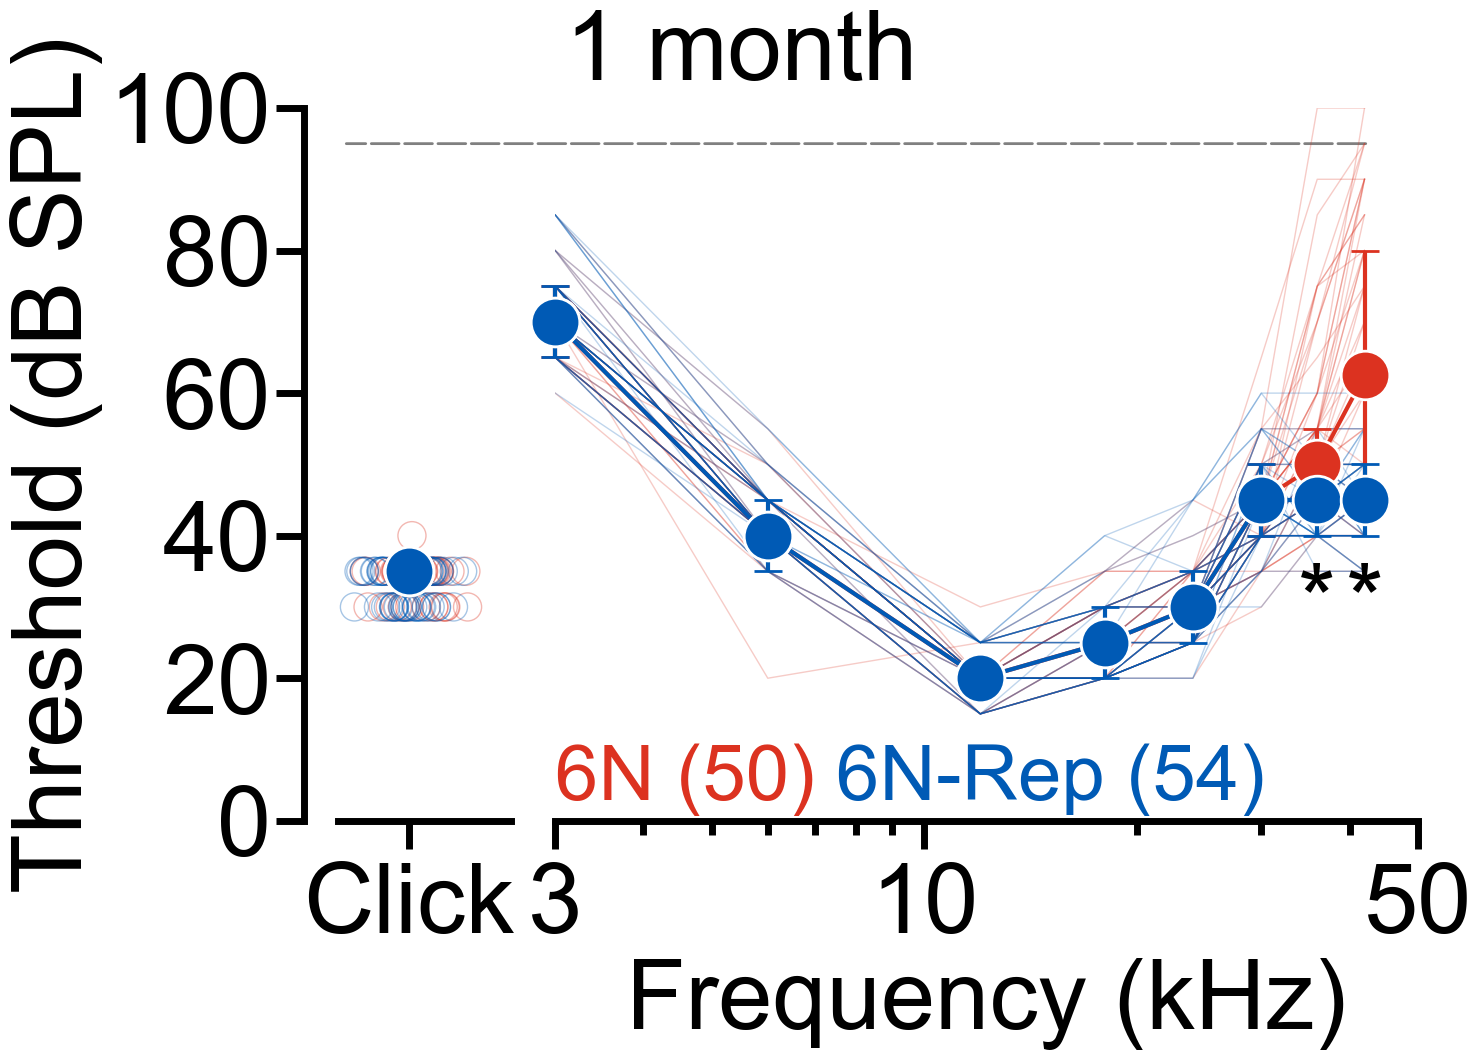

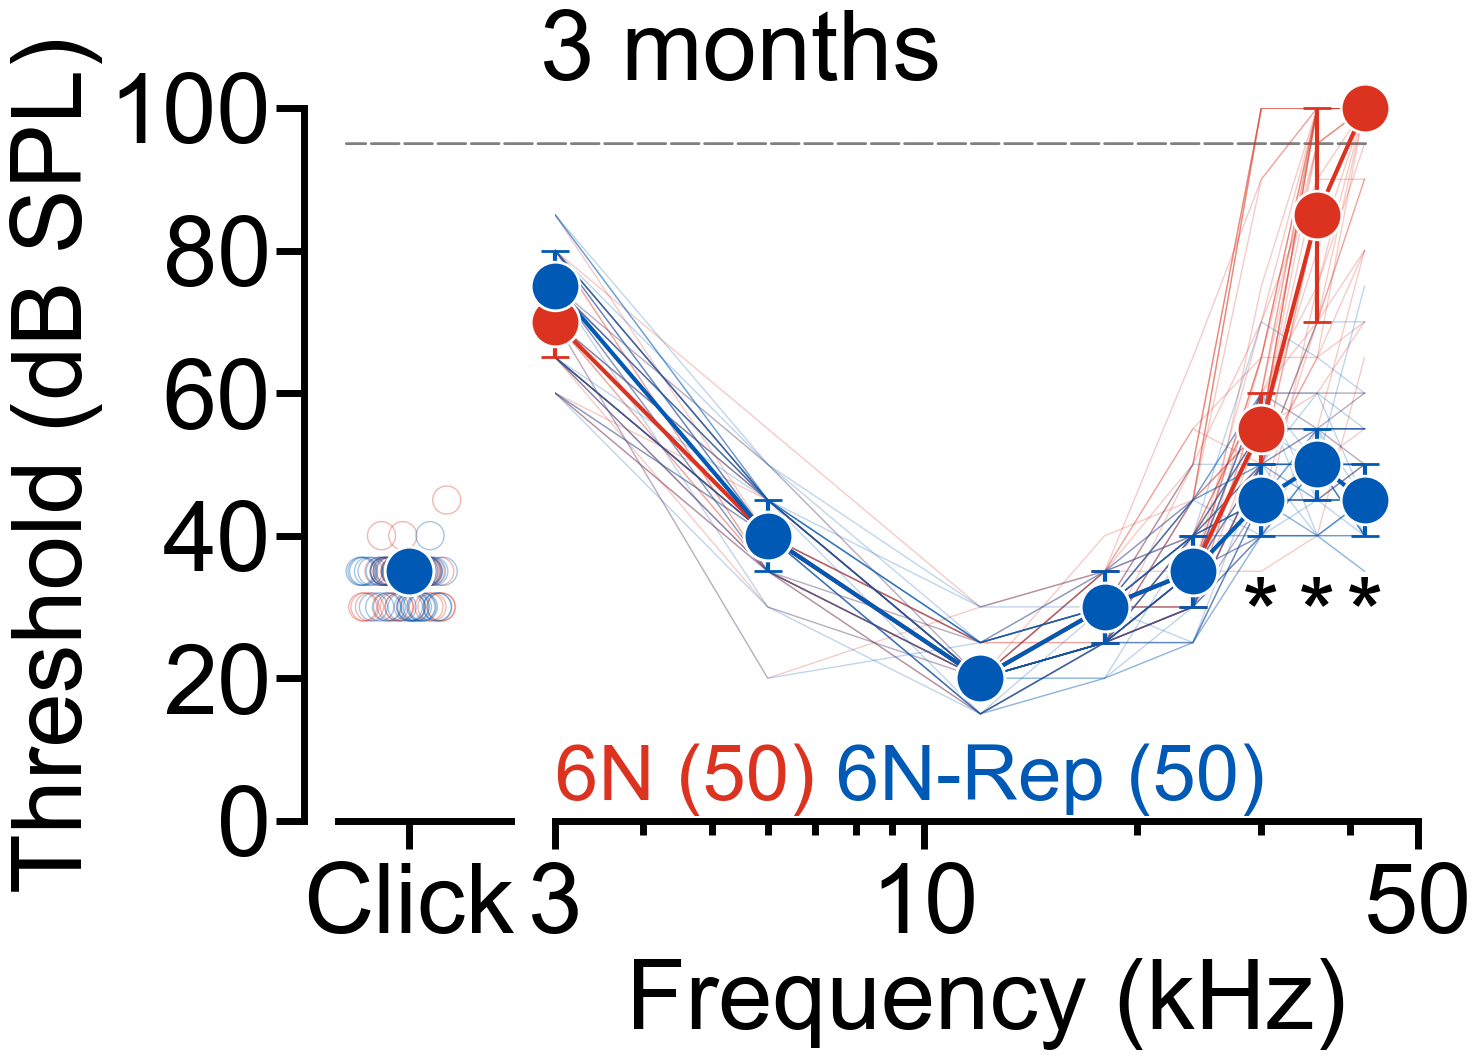

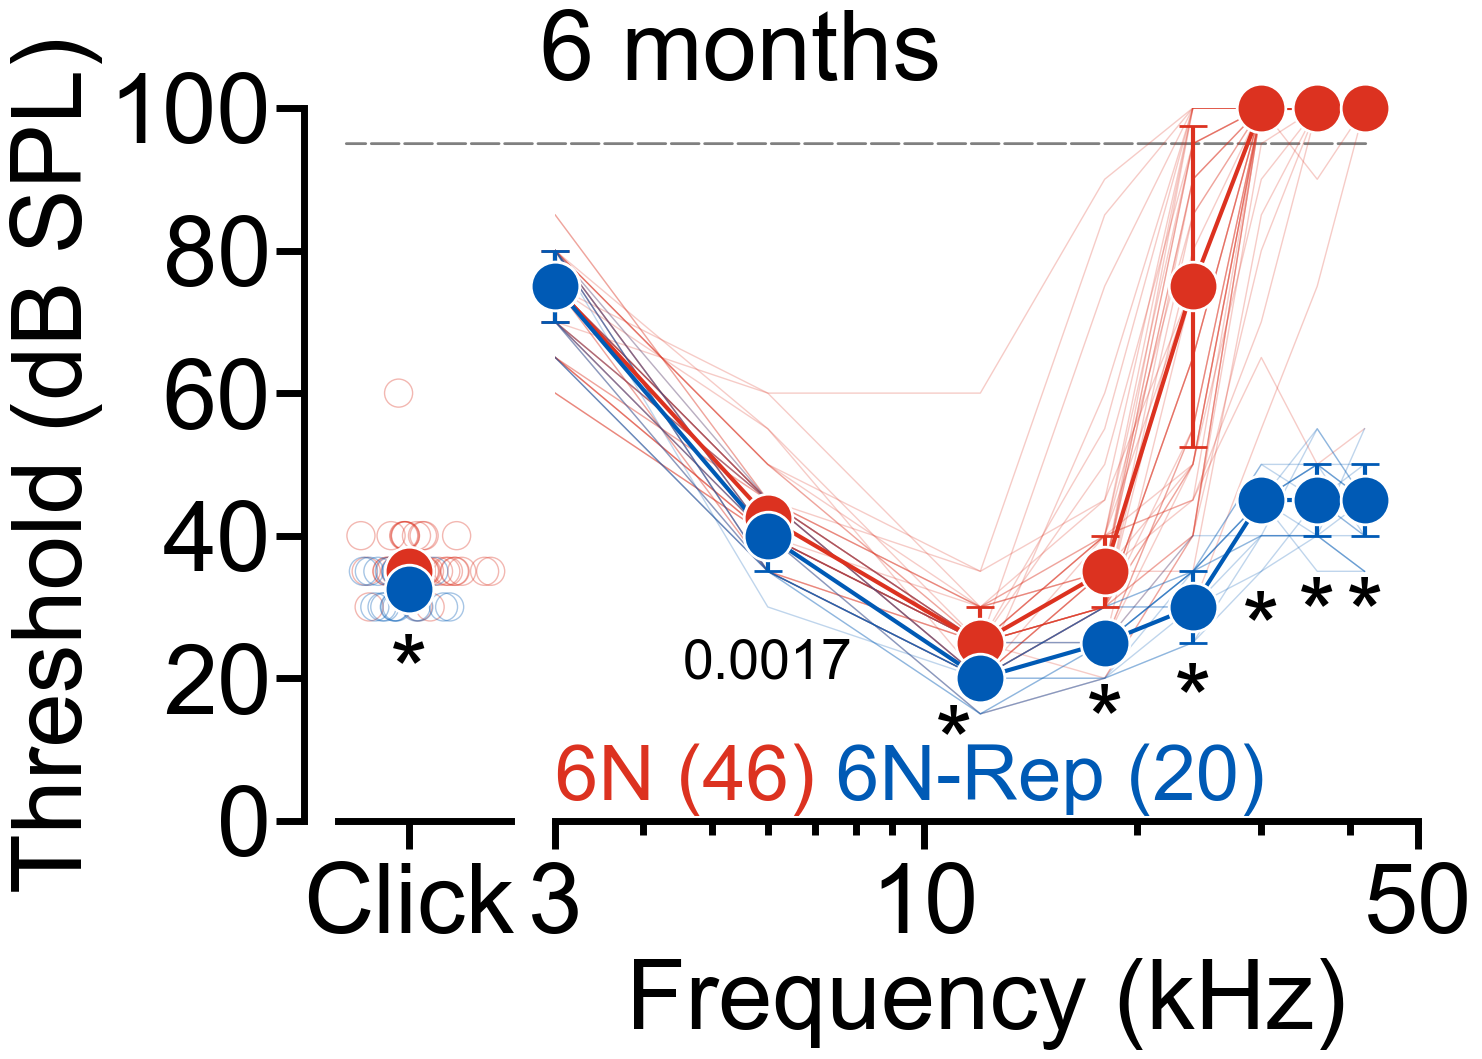

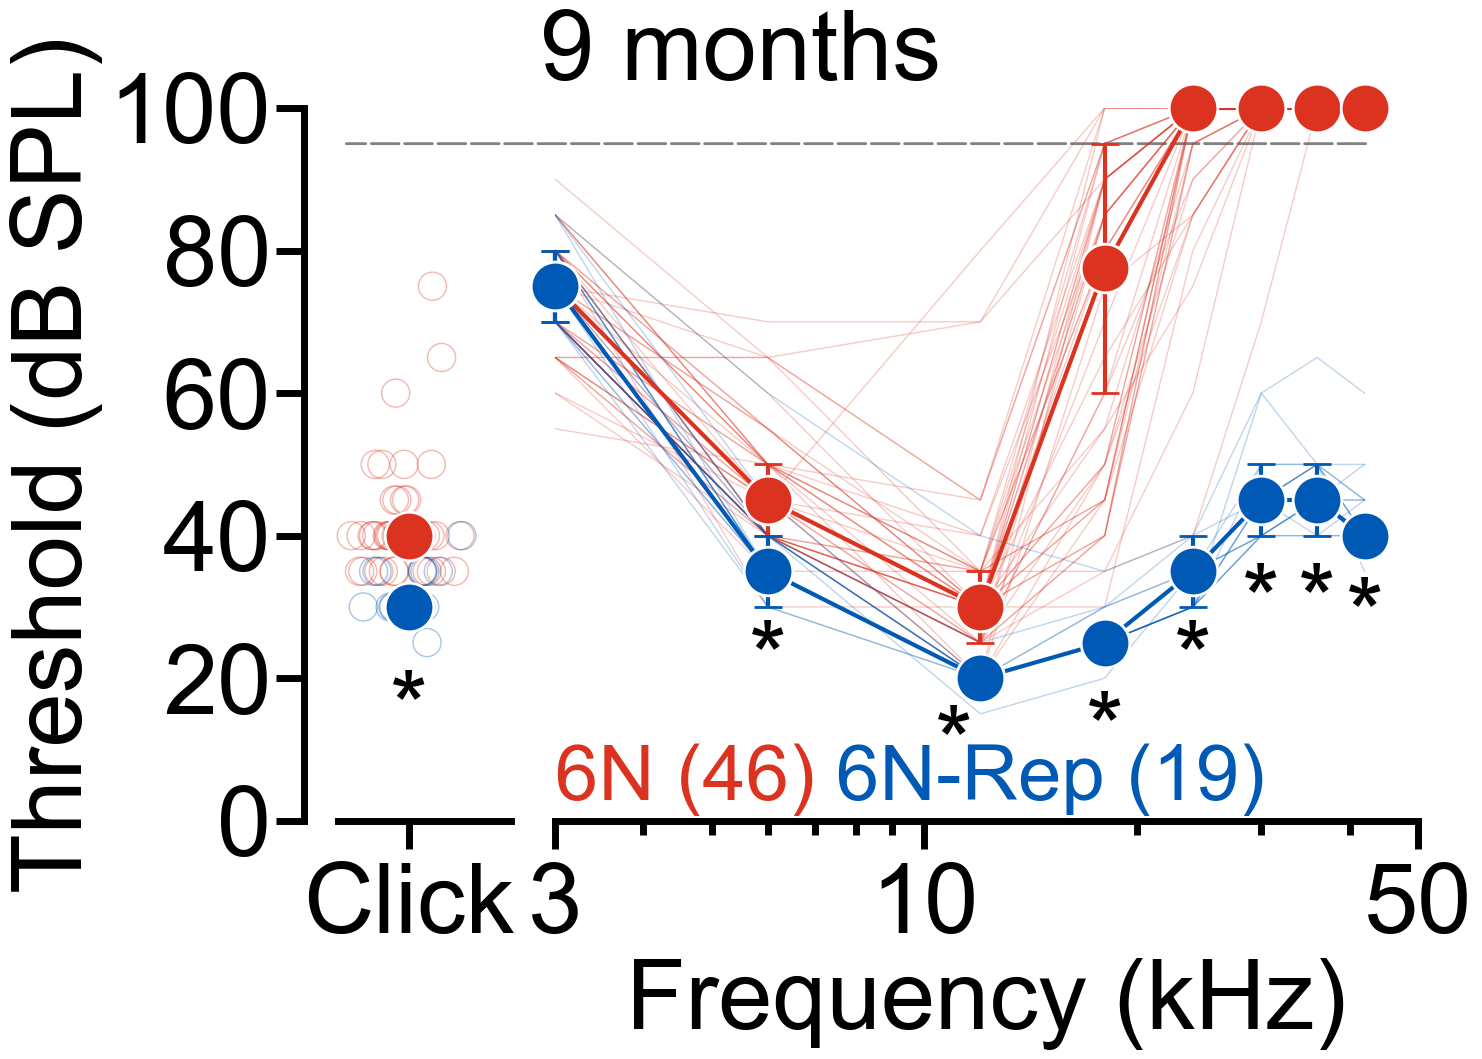

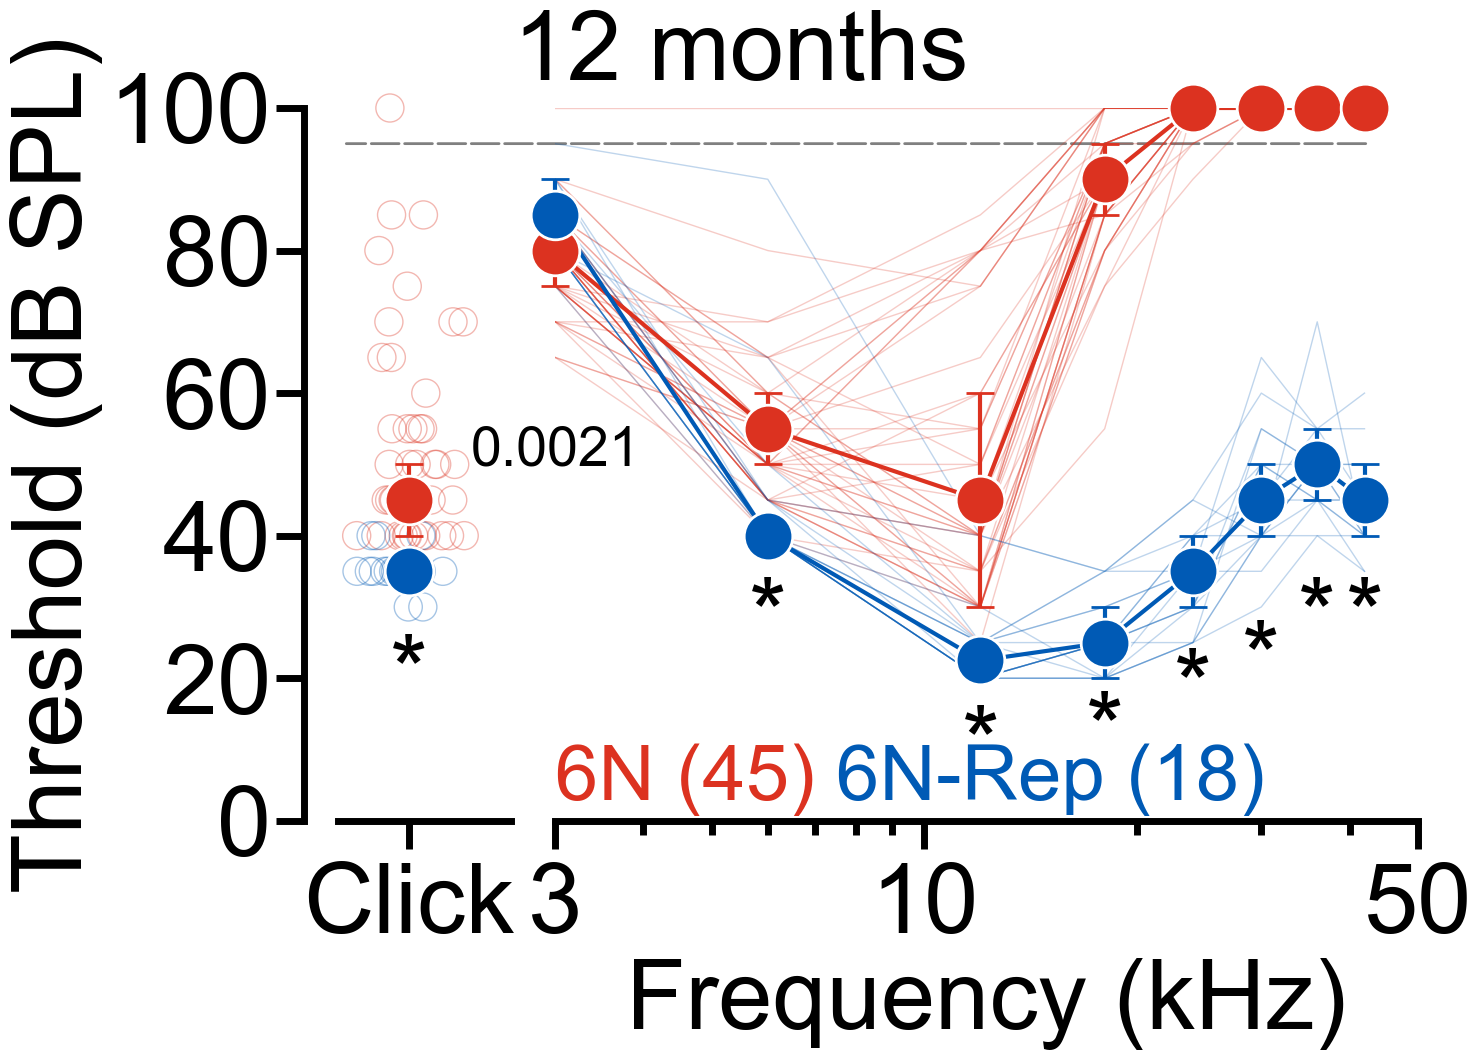

In [13]:
fontSize2 = 70
for age in [1,3,6,9,12]:
    tr6N = thresholds[(thresholds['Strain']=='6N') & (thresholds['Age (months)']==age)][frequencies]

    trRepaired = thresholds[(thresholds['Strain']=='Repaired') & (thresholds['Age (months)']==age)][frequencies]

    ax,ax2=makeAvgThreshFigure2(tr6N,trRepaired)
    if age == 1:
        text(42000,30,'*',fontsize=fontSize2,ha='center',va='center')
        text(36000,30,'*',fontsize=fontSize2,ha='center',va='center')
    elif age==3:
        text(42000,28,'*',fontsize=fontSize2,ha='center',va='center')
        text(36000,28,'*',fontsize=fontSize2,ha='center',va='center')
        text(30000,28,'*',fontsize=fontSize2,ha='center',va='center')   
    elif age==6:
        text(42000,28,'*',fontsize=fontSize2,ha='center',va='center')
        text(36000,28,'*',fontsize=fontSize2,ha='center',va='center')
        text(30000,26,'*',fontsize=fontSize2,ha='center',va='center')        
        text(24000,16,'*',fontsize=fontSize2,ha='center',va='center')   
        text(18000,13,'*',fontsize=fontSize2,ha='center',va='center')   
        
        text(11000,10,'*',fontsize=fontSize2,ha='center',va='center') 
        text(6000,22,'0.0017',fontsize=40,ha='center',va='center') 
        ax.text(0,20,'*',fontsize=fontSize2,ha='center',va='center') 
    elif age==9:
        text(42000,28,'*',fontsize=fontSize2,ha='center',va='center')
        text(36000,30,'*',fontsize=fontSize2,ha='center',va='center')
        text(30000,30,'*',fontsize=fontSize2,ha='center',va='center')        
        text(24000,22,'*',fontsize=fontSize2,ha='center',va='center')   
        text(18000,12,'*',fontsize=fontSize2,ha='center',va='center') 
        text(11000,10,'*',fontsize=fontSize2,ha='center',va='center') 
        text(6000,22,'*',fontsize=fontSize2,ha='center',va='center') 
        ax.text(0,15,'*',fontsize=fontSize2,ha='center',va='center') 
    elif age==12:
        text(42000,28,'*',fontsize=fontSize2,ha='center',va='center')
        text(36000,28,'*',fontsize=fontSize2,ha='center',va='center')
        text(30000,22,'*',fontsize=fontSize2,ha='center',va='center')        
        text(24000,18,'*',fontsize=fontSize2,ha='center',va='center')   
        text(18000,12,'*',fontsize=fontSize2,ha='center',va='center') 
        text(12000,10,'*',fontsize=fontSize2,ha='center',va='center') 
        text(6000,28,'*',fontsize=fontSize2,ha='center',va='center') 
        text(3000,52,'0.0021',fontsize=40,ha='center',va='center') 

        ax.text(0,20,'*',fontsize=fontSize2,ha='center',va='center') 
    savefig('./Panels/audiogram'+str(age)+'.pdf',transparent=True,dpi=1200)

# Determine the maximum spread at each age in 6N mice

In [14]:
colmns = ['Click', '3 kHz', '6 kHz', '12 kHz', '18 kHz', '24 kHz','30 kHz', '36 kHz', '42 kHz']
dfmin = thresholds[thresholds['Strain']=='6N'].groupby(['Age (months)']).agg(['min'])[colmns]
dfmin.columns = dfmin.columns.droplevel(1)
dfmin

dfmax = thresholds[thresholds['Strain']=='6N'].groupby(['Age (months)']).agg(['max'])[colmns]
dfmax.columns = dfmax.columns.droplevel(1)
dfdiff = dfmax-dfmin


In [15]:
dfmax

,Click,3 kHz,6 kHz,12 kHz,18 kHz,24 kHz,30 kHz,36 kHz,42 kHz
Age (months),,,,,,,,,
1,40,85,55,30,35,45,65,100,100
3,45,85,55,30,40,65,100,100,100
6,60,85,60,60,90,100,100,100,100
9,75,90,70,80,100,100,100,100,100
12,100,100,100,100,100,100,100,100,100


In [16]:
dfdiff

,Click,3 kHz,6 kHz,12 kHz,18 kHz,24 kHz,30 kHz,36 kHz,42 kHz
Age (months),,,,,,,,,
1,10,25,35,15,15,25,35,65,65
3,15,25,35,15,15,40,65,60,55
6,30,25,25,45,70,70,45,50,45
9,40,35,40,60,70,60,30,0,0
12,60,35,60,75,45,10,0,0,0


In [17]:
print('Maximum spread for every age at different frequencies')
dfdiff.max()

Maximum spread for every age at different frequencies


Click     60
3 kHz     35
6 kHz     60
12 kHz    75
18 kHz    70
24 kHz    70
30 kHz    65
36 kHz    65
42 kHz    65
dtype: int64

# Plot audiogram as rasterplots for individual mice

In [18]:
#Find the mice that have a full dataset
fullDatasetsIDs = []
for idx in thresholds['ID'].unique():
    if thresholds.query("ID==@idx").shape[0]==5:
        fullDatasetsIDs.append(idx)

thresholdsFull = thresholds.query("ID.isin(@fullDatasetsIDs)")
thresholdsFull = thresholdsFull.sort_values('Strain')

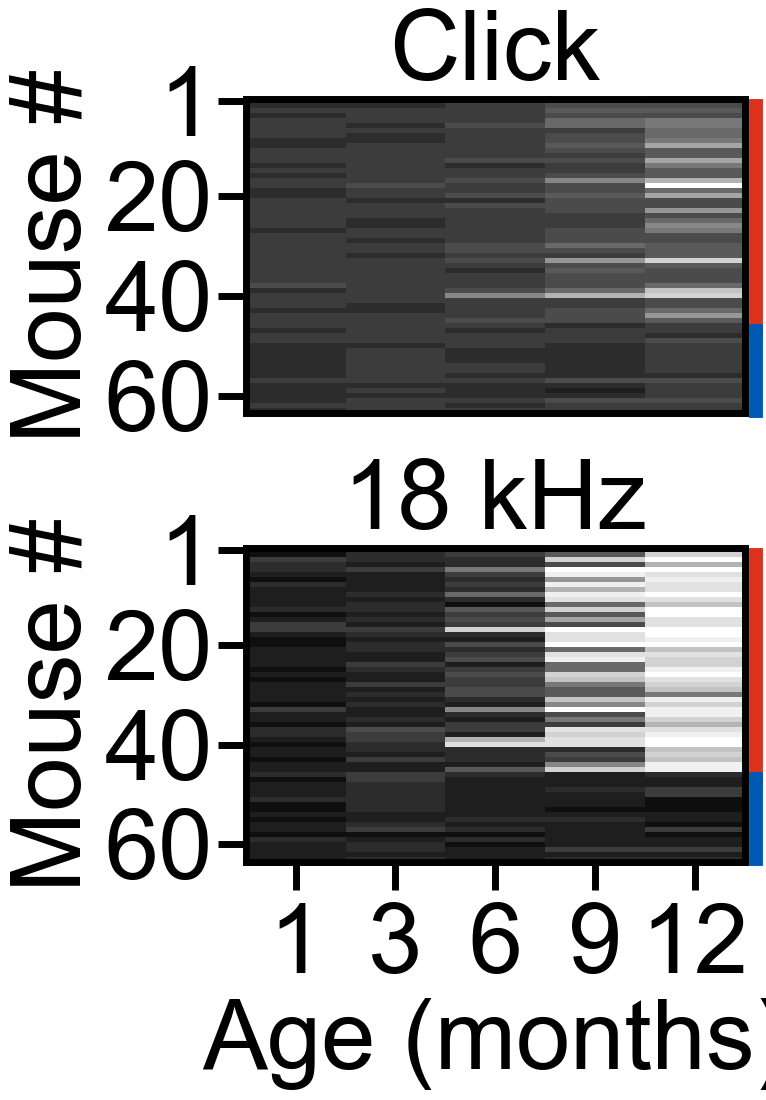

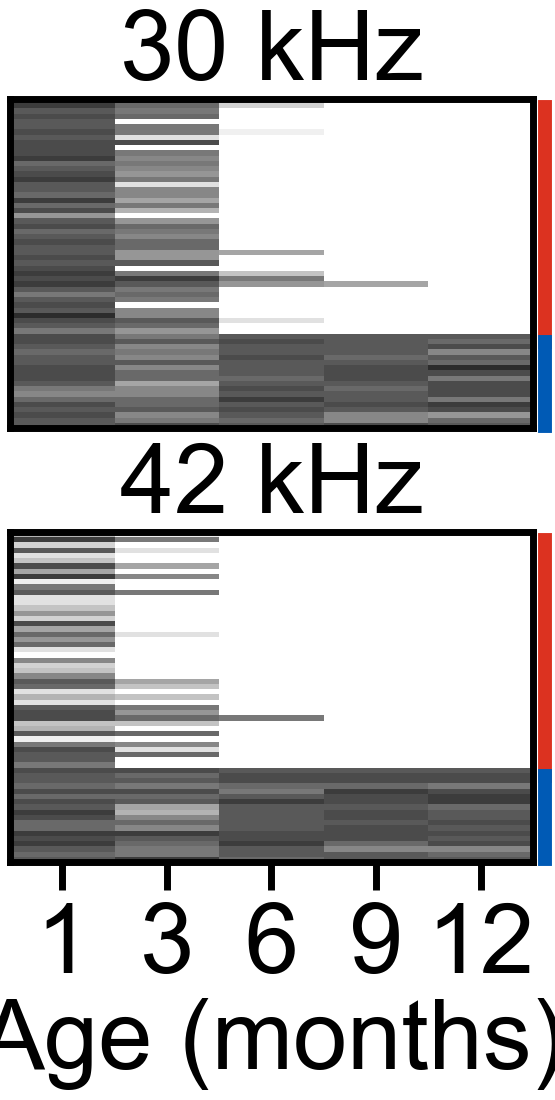

In [19]:
f=figure(figsize=(3.7*2.5*1.6138,3.7*2.5*1.2))

gs= gridspec.GridSpec(2,1,height_ratios=[1,1],hspace=0,figure=f)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.imshow(thresholdsFull.groupby(['Strain','ID','Age (months)'])['Click'].mean().reset_index().pivot(index='ID',columns='Age (months)').sort_values(('Strain',1))['Click'],
                                                        aspect=.05,interpolation='None',cmap=cm.gray,vmin=15,vmax=100)
ax2.imshow(thresholdsFull.groupby(['Strain','ID','Age (months)'])['18 kHz'].mean().reset_index().pivot(index='ID',columns='Age (months)').sort_values(('Strain',1))['18 kHz']
                                                        ,aspect=.05,interpolation='None',cmap=cm.gray,vmin=15,vmax=100)

#Plot the lines on the side for showing which mice are which
ax1.plot([4.62,4.62],[1,thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+1],'#DC3220', linewidth=10,clip_on=False)
ax1.plot([4.62,4.62],[thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+1,
         thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['Repaired']-1],'#005AB5', linewidth=10,clip_on=False)
ax2.plot([4.62,4.62],[1,thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+1],'#DC3220', linewidth=10,clip_on=False)
ax2.plot([4.62,4.62],[thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+1,
         thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['Repaired']-1],'#005AB5', linewidth=10,clip_on=False)

ax2.set_xlim(-0.5,4.5)

ax1.set_xlim(-0.5,4.5)
ax1.set_title('Click')
ax2.set_title('18 kHz')

ax1.spines.right.set_visible(True)
ax1.spines.top.set_visible(True)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.xaxis.set_visible(False)

xticks([0,1,2,3,4],['1','3','6','9','12'])
xlabel('Age (months)')
ylabel('Mouse #')
ax1.set_ylabel('Mouse #')
ax1.set_yticks([0,19,39,59],[1,20,40,60])
ax2.set_yticks([0,19,39,59],[1,20,40,60])

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
            ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(fontSize)

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(fontSize)
    
gs.tight_layout(f)
savefig('./Panels/Rasterplots.pdf',transparent=True,dpi=1200)


###Second figure
#30 and 42 kHz
f=figure(figsize=(3.7*2.5*1.6138,3.7*2.5*1.2))

gs= gridspec.GridSpec(2,1,height_ratios=[1,1],hspace=0,figure=f)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.imshow(thresholdsFull.groupby(['Strain','ID','Age (months)'])['30 kHz'].mean().reset_index().pivot(index='ID',columns='Age (months)').sort_values(('Strain',1))['30 kHz'],
                                                    aspect=.05,interpolation='None',cmap=cm.gray,vmin=15,vmax=100)

ax2.imshow(thresholdsFull.groupby(['Strain','ID','Age (months)'])['42 kHz'].mean().reset_index().pivot(index='ID',columns='Age (months)').sort_values(('Strain',1))['42 kHz']
                                                    ,aspect=.05,interpolation='None',cmap=cm.gray,vmin=15,vmax=100)
ax1.plot([4.62,4.62],[1,thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+1],'#DC3220', linewidth=10,clip_on=False)
ax1.plot([4.62,4.62],[thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+1,
         thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['Repaired']-1],'#005AB5', linewidth=10,clip_on=False)
ax1.set_xlim(-0.5,4.5)
ax2.plot([4.62,4.62],[1,thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+1],'#DC3220', linewidth=10,clip_on=False)
ax2.plot([4.62,4.62],[thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+1,
         thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['6N']+thresholdsFull.query("`Age (months)`==1")['Strain'].value_counts()['Repaired']-1],'#005AB5', linewidth=10,clip_on=False)

ax2.set_xlim(-0.5,4.5)


ax1.set_title('30 kHz')
ax2.set_title('42 kHz')

#ax1.spines.right.set_visible(False)
#ax2.spines.right.set_visible(False)
ax1.spines.top.set_visible(True)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.xaxis.set_visible(False)


xticks([0,1,2,3,4],['1','3','6','9','12'])
xlabel('Age (months)')
#ylabel('Mouse #')
#ax1.set_ylabel('Mouse #')
ax1.set_yticks([])
ax2.set_yticks([])

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
            ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(fontSize)

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(fontSize)
 
gs.tight_layout(f)

savefig('./Panels/Rasterplots_2.pdf',transparent=True,dpi=1200)



Generate a colorbar for the above raster plots

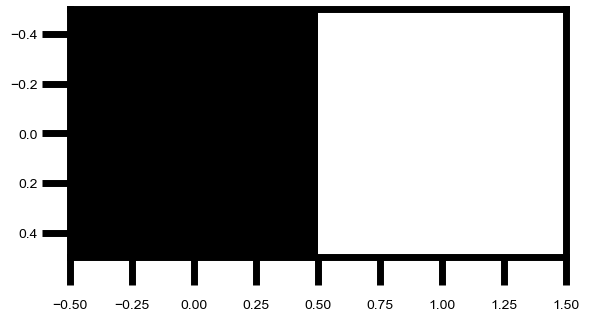

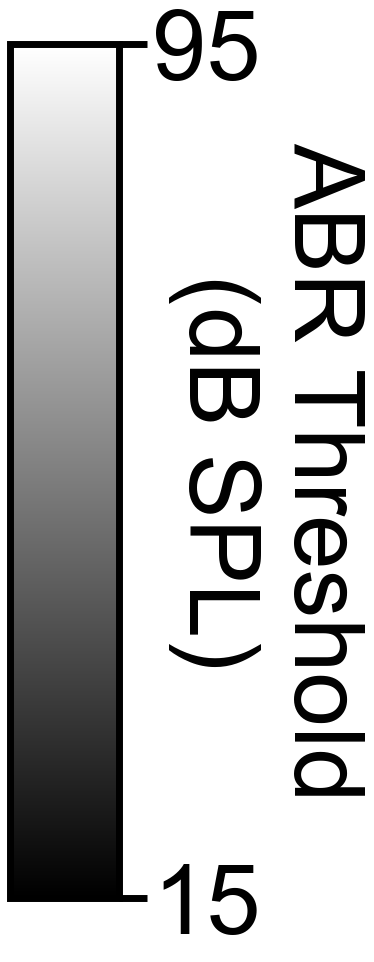

In [20]:
a = np.array([[0,1]])


img = imshow(a, cmap=cm.gray)
f=figure(figsize=(3.7*2.5*1.6138,3.7*2.5*1.2))
gs= gridspec.GridSpec(2,2,width_ratios=[10,1],height_ratios=[1,7],hspace=0,figure=f)
#ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[3])



colorbar(orientation="vertical", cax=ax2,mappable=img)
ax2.set_yticks([0,1],[15,95])
ax2.set_ylabel('ABR Threshold\n(dB SPL)',rotation=-90, va='center')
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
            ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(fontSize)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(fontSize)
gs.tight_layout(f)
savefig('./Panels/Rasterplots_colorbar.pdf',transparent=True,dpi=1200)